In [6]:
%matplotlib widget

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

from dataclasses import dataclass

In [7]:
# set up dynamics

def calc_interia(mass, dims):  # about the tip of the pen
    # pen, solid cylinder http://hyperphysics.phy-astr.gsu.edu/hbase/icyl.html
    I_pen_central = mass['pen'] * (dims['pen_r']**2 / 4 + dims['pen_h']**2 / 12)
    # shift to edge of cylinder https://pressbooks.online.ucf.edu/osuniversityphysics/chapter/10-5-calculating-moments-of-inertia/
    I_pen = I_pen_central + mass['pen'] * (dims['pen_h']/2)**2
    # cube, solid cube https://en.wikipedia.org/wiki/List_of_moments_of_inertia
    I_cube_central = mass['cube'] * (dims['cube_a']**2 / 6)
    # shift to edge of cube https://pressbooks.online.ucf.edu/osuniversityphysics/chapter/10-5-calculating-moments-of-inertia/
    I_cube = I_cube_central + mass['cube'] * (dims['cube_a']/2 + dims['pen_h'])**2
    I = I_pen + I_cube
    center_of_mass = (mass['pen'] * dims['pen_h'] / 2 + mass['cube'] *
                      (dims['cube_a']/2 + dims['pen_h'])) / (mass['pen'] + mass['cube'])
    I_wheel = mass['wheel']/2 * (2*dims['wheel_r_inner'] *
                                 dims['wheel_thickness'] + dims['wheel_thickness']**2)
    I_cmg = 6.79e-6
    return I, I_wheel, I_cmg, center_of_mass


def get_mgl_I():
    DENSITY = {  # kg/m^3
        'aluminium': 2700,
        'iron': 7870,
    }
    DIMS = {  # m
        'pen_r': 5e-3,
        'pen_h': 2e-1,
        'cube_a': 5e-2,
        'wheel_r_inner': 5e-2,
        'wheel_thickness': 1e-2,
        'wheel_width': 1e-2,
    }
    MASS = {  # kg
        'pen': DENSITY['aluminium'] * np.pi * DIMS['pen_r']**2 * DIMS['pen_h'],
        'cube': DENSITY['aluminium'] * DIMS['cube_a']**3,
        'wheel': DENSITY['aluminium'] * np.pi * (2*DIMS['wheel_r_inner'] * DIMS['wheel_thickness'] + DIMS['wheel_thickness']**2) * DIMS['wheel_width'],
        'cmg': 3.39e-2,
    }
    I, I_wheel, I_cmg, center_of_mass = calc_interia(MASS, DIMS)
    return ((MASS['pen'] + MASS['cube']) * sp.constants.g * center_of_mass) / I, I, I_wheel, I_cmg


mgl_I, I, I_wheel, I_cmg = get_mgl_I()
print(get_mgl_I())


def xdot_rw(t, x, u):
    return np.array([x[1],
                     (mgl_I * x[0]) - u/I])


CMG_SPEED = 104.7  # rad/s


def xdot_cmg(t, x, u):
    return np.array([x[1],
                    #  (mgl_I * x[0]) - I_cmg*CMG_SPEED/I + (u*I_cmg*CMG_SPEED)/I])
                     (mgl_I * x[0]) - (u*I_cmg*CMG_SPEED)/I])

(44.19233764663156, 0.017792314249526313, 5.1317915996389284e-05, 6.79e-06)


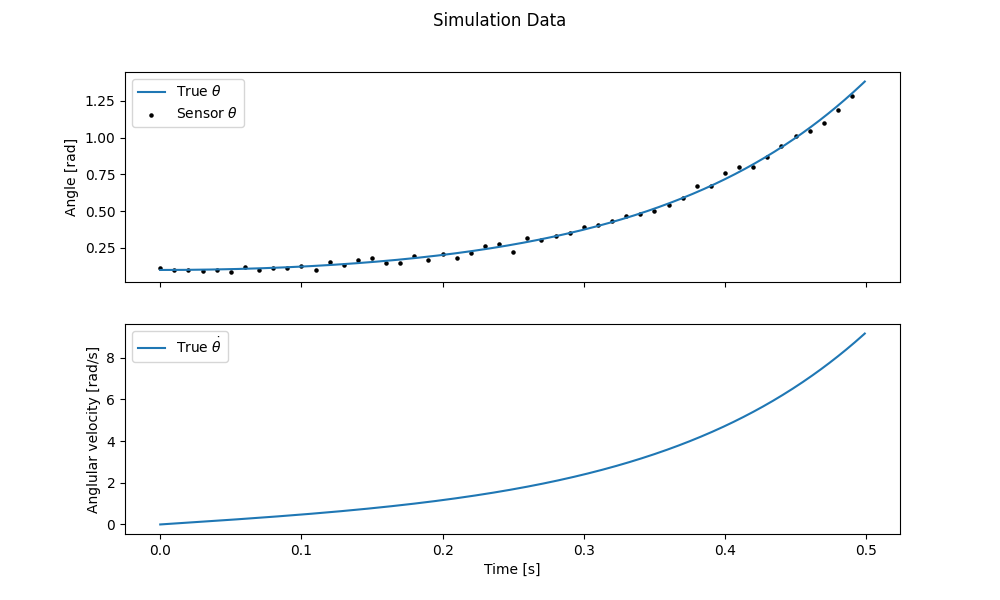

In [8]:
# simulate system
X0 = np.array([0.1, 0])
Tstart = 0
Tend = 0.5
Tstep = 0.001  # 1ms
sens_interval = 10  # every 10th step
sens_noise_std = 0.02


@dataclass
class Data:
    t: np.ndarray
    y: np.ndarray


def generate_data(xdot, X0, Tstart, Tend, Tstep, sens_interval, sens_noise_std):
    sol = sp.integrate.solve_ivp(xdot, [Tstart, Tend], X0, t_eval=np.arange(Tstart, Tend, Tstep))
    truth = Data(sol.t, sol.y)
    sensor = Data(sol.t[::sens_interval],
                  # only measure angle, add noise
                  sol.y[0, ::sens_interval] + np.random.randn(1, len(sol.t[::sens_interval])) * sens_noise_std)
    # measure both, add noise
    #   sol.y[:, ::sens_interval] + np.random.randn(sol.y.shape[0], len(sol.t[::sens_interval])) * sens_noise_std)
    return truth, sensor


def plot_data(fignum, truth, sensor):
    plt.close(fignum)
    fig, axs = plt.subplots(2, 1, figsize=(10, 6), num=fignum, sharex=True)
    fig.suptitle('Simulation Data')
    axs[0].plot(truth.t, truth.y[0], label=r'True $\theta$')
    axs[0].set_ylabel('Angle [rad]')
    axs[0].scatter(sensor.t, sensor.y, marker='o', c='k', s=5, label=r'Sensor $\theta$')
    axs[0].legend()
    axs[1].plot(truth.t, truth.y[1], label=r'True $\dot{\theta}$')
    # plt.scatter(sensor.t, sensor.y[0], label='Sensor Angle')
    # plt.scatter(sensor.t, sensor.y[1], label='Sensor Angular Velocity')
    axs[1].set_xlabel('Time [s]')
    axs[1].set_ylabel('Anglular velocity [rad/s]')
    axs[1].legend()
    fig.savefig('figs/plot_data.svg')
    plt.show()
    return fignum + 1


def xdot_rw_u(t, x):
    return xdot_rw(t, x, 0)


truth, sensor = generate_data(xdot_rw_u, X0, Tstart, Tend, Tstep, sens_interval, sens_noise_std)
fignum = 1
fignum = plot_data(fignum, truth, sensor)

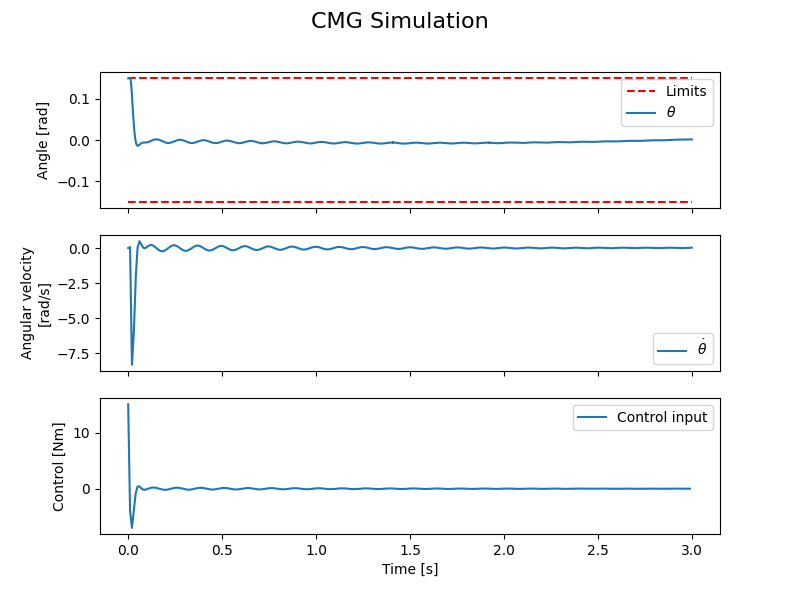

In [37]:
# set up simulation


def simulate(xdot, x0, u0, Kp, Ki, Kd, Tstart, Tend, Tstep, max_u, sens_interval, sens_noise_std):
    u = u0
    x = x0
    prop = 0
    prop_prev = 0
    integ_arr = []
    integ = 0

    Kp = .01
    Ki = 1
    Kd = 1

    tx = np.zeros((int((Tend - Tstart) / Tstep)))
    xdata = np.zeros((x.shape[0], int((Tend - Tstart) / Tstep)))

    tu = np.zeros((int((Tend - Tstart) / (Tstep*sens_interval))))
    udata = np.zeros((int((Tend - Tstart) / (Tstep*sens_interval))))

    i = 0
    for t in np.arange(Tstart, Tend, Tstep*sens_interval):
        def xdot_u(t, x):
            return xdot(t, x, u)
        t_span = [t, t + Tstep*sens_interval]  # simulate for this time
        # return results at these times
        t_eval = np.linspace(t, t + Tstep*sens_interval, sens_interval)
        sol = sp.integrate.solve_ivp(xdot_u, t_span, x, t_eval=t_eval)
        x = sol.y[:, -1]  # sense the theta of the last simulated step

        y = (x[0] + np.random.randn(1) * sens_noise_std)[0]

        prop = y

        # integ_arr.append(prop * (Tstep*sens_interval))
        # if len(integ_arr) > 10:
        #     integ_arr.pop(0)
        # integ = np.sum(integ_arr)
        integ += prop * (Tstep*sens_interval)
        # integ += prop

        der = (prop - prop_prev) / (Tstep*sens_interval)
        # der = prop - prop_prev

        # if i > 0:
        u = Kp * prop + Ki * integ + Kd * der
        # u = Kp * prop
        u = np.clip(u, -max_u, max_u)
        u += np.sin(50*t) * np.exp(-t) * .25
        # u = .15
        # print(f't: {t}, prop: {prop}, integ: {integ}, der: {der}, u: {u}')

        i_x_start = i * sens_interval
        i_x_end = i_x_start + sens_interval
        tx[i_x_start:i_x_end] = sol.t
        xdata[:, i_x_start:i_x_end] = sol.y

        tu[i] = t
        udata[i] = u

        prop_prev = prop
        i += 1

    return tx, xdata, tu, udata


def plot_simulation(fignum, tx, xdata, tu, udata, limit_angle, limit_torque):
    plt.close(fignum)
    fig, axs = plt.subplots(3, 1, figsize=(8, 6), num=fignum, sharex=True)
    fig.suptitle('CMG Simulation', size=16)
    ax_ang = axs[0]
    ax_ang.hlines([limit_angle, -limit_angle], tx[0], tx[-1], 'r', '--', label='Limits')
    ax_ang.plot(tx, xdata[0, :], label=r'$\theta$')
    ax_ang.set_ylabel('Angle [rad]')
    ax_ang.legend()

    ax_vel = axs[1]
    ax_vel.plot(tx, xdata[1, :], label=r'$\dot{\theta}$')
    ax_vel.set_ylabel('Angular velocity\n[rad/s]')
    ax_vel.legend()

    ax_u = axs[2]
    # ax_u.hlines([limit_torque, -limit_torque], tu[0], tu[-1], 'r', '--', label='Limits')
    ax_u.plot(tu, udata, label='Control input')
    ax_u.set_xlabel('Time [s]')
    ax_u.set_ylabel('Control [Nm]')
    ax_u.legend()

    fig.savefig('figs/simulate.svg')
    plt.show()

    return fignum + 1


X0 = np.array([0.15, 0])
max_torque = 1000  # Nm
noise_std = 0
tx, xdata, tu, udata = simulate(xdot_rw, X0, u0=0, Kp=-1, Ki=-10, Kd=-1, Tstart=0, Tend=3, Tstep=0.001,
                                max_u=max_torque, sens_interval=10, sens_noise_std=0)
angle_limit = 0.15  # limit for angle in rad
fignum = plot_simulation(fignum, tx, xdata, tu, udata, angle_limit, max_torque)

t: 0.0, prop: 0.1503315646117202, integ: 0.0015033156461172021, der: 15.03315646117202, u: 15.036163092464253
t: 0.01, prop: 0.15129767379776007, integ: 0.003016292384094803, der: 0.09661091860398707, u: 0.10114018772605948
t: 0.02, prop: 0.15290239645806725, integ: 0.004545316348675475, der: 0.1604722660307173, u: 0.16654660634397345
t: 0.03, prop: 0.155182544447966, integ: 0.006097141793155136, der: 0.22801479898987564, u: 0.23566376622751045
t: 0.04, prop: 0.1581479291344528, integ: 0.007678621084499664, der: 0.29653846864867994, u: 0.3057985690245241
t: 0.05, prop: 0.1618113817711476, integ: 0.00929673490221114, der: 0.36634526366947917, u: 0.37726011238940177
t: 0.06, prop: 0.16618881498802146, integ: 0.010958623052091354, der: 0.4377433216873866, u: 0.45036383288935816
t: 0.07, prop: 0.17129929189076978, integ: 0.012671615970999053, der: 0.5110476902748323, u: 0.5254322991647391
t: 0.08, prop: 0.17716510906107977, integ: 0.01444326706160985, der: 0.5865817170309984, u: 0.60279663

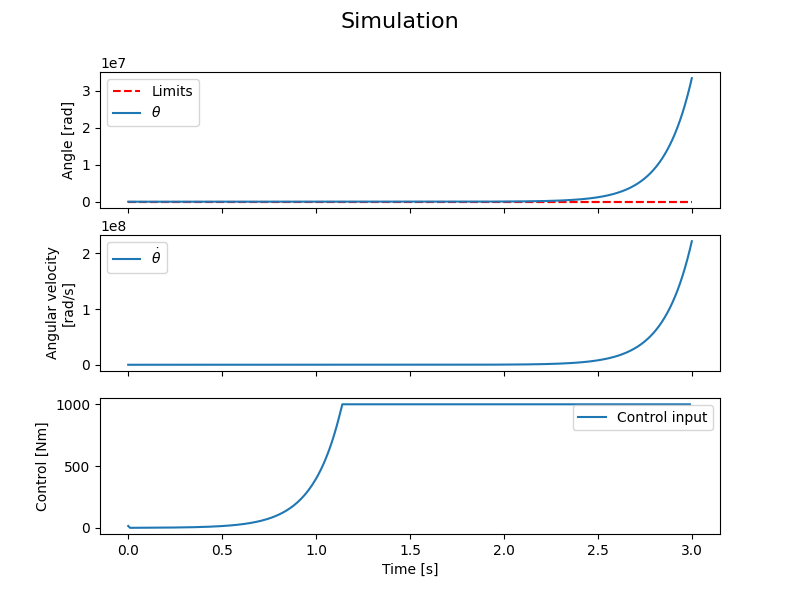

In [14]:
X0 = np.array([0.15, 0])
max_torque = 1000  # Nm
noise_std = 0
tx, xdata, tu, udata = simulate(xdot_cmg, X0, u0=0, Kp=0.1, Ki=1, Kd=-1, Tstart=0, Tend=3, Tstep=0.001,
                                max_u=max_torque, sens_interval=10, sens_noise_std=0)
angle_limit = 0.15  # limit for angle in rad
fignum = plot_simulation(fignum, tx, xdata, tu, udata, angle_limit, max_torque)